# Solution for compulsary exercise 2 - TKT4196 2021

In [1]:
import numpy as np
import scipy as sp
from scipy.stats import multivariate_normal as mvn
import matplotlib.pyplot as plt
import scipy.stats
import time
import sympy as sym

fontsizes=18
plt.rcParams.update({'font.size': fontsizes})
plt.rcParams.update({"font.family": "serif"})
plt.rcParams.update({"mathtext.fontset" : "cm"})
plt.rcParams.update({'font.serif': 'Times New Roman'})
plt.close('all')

Save all basic values given, awaiting transformation to u-space

In [2]:
# =============================================================================
# INPUT

mu_dt = 1.12
V_dt = 0.32
std_dt = mu_dt * V_dt

mu_df = 1.1
V_df= 0.2
std_df = mu_df * V_df

mu_N1 = 40
V_N1 = 0.3
std_N1 = mu_N1 * V_N1

mu_N2 = 60
V_N2 = 0.2
std_N2 = mu_N2 * V_N2

mu_G1 = 400000                                    #N
V_G1 = 0.1 
std_G1 = mu_G1 * V_G1                             #N

mu_Q = 500000                                     #N
V_Q = 0.35
std_Q = mu_Q * V_Q                                #N

l1 = 5000                                         #mm

rho_rc = 25*1e-6                                  #N/mm^3

A = lambda d: np.pi/4 * d**2                      # Defining function for area of the pile [mm2]
C = lambda d: np.pi * d                           # Defining function for circumference of the pile [mm]
G2 = lambda h,d: A(d) * h * rho_rc                # Defining function for self weight of the pile [N]

k1 = 0.01                                         # constant in front of N_1 in c_1 [N/mm2]
k2 = 0.005                                        # constant in front of N_2 in c_2 [N/mm2]

Function calculating parameters from moments as defined in Exercise 3:

In [3]:
def addparams(X):
    moments = X['moments']
    if X['type'] == 'Normal':
        theta = X['moments']
    if X['type'] == 'Lognormal':
        sigma_ln = np.sqrt(np.log(moments[1]**2/moments[0]**2+1))
        mu_ln = np.log(moments[0])-0.5*sigma_ln**2
        theta = [mu_ln,sigma_ln]
    if X['type'] == 'Gumbel':
        a = np.pi/np.sqrt(6)/moments[1]
        b = moments[0] - 0.5772/a
        theta = [a,b]
    X['theta']=theta

### Transformed input
We use dictionaries here to allow type to be defined and utilised

In [4]:
#TRANSFORMED INPUT
G1 = {}
G1['type'] = "Gumbel"
G1['moments'] = [mu_G1,std_G1]
addparams(G1)

Q = {}
Q['type'] = "Gumbel"
Q['moments'] = [mu_Q,std_Q]
addparams(Q)

N1 = {}
N1['type'] = "Lognormal"
N1['moments'] = [mu_N1,std_N1]
addparams(N1)

N2 = {}
N2['type'] = "Lognormal"
N2['moments'] = [mu_N2,std_N2]
addparams(N2)

dt = {}
dt['type'] = "Normal"
dt['moments'] = [mu_dt,std_dt]
addparams(dt)

df = {}
df['type'] = "Normal"
df['moments'] = [mu_df,std_df]
addparams(df)

Limit state function in the X-space

$$ g_X(R_t,R_s,G_1,G_2,Q) = (R_t + R_s) - (G_1 + G_2 + Q) $$

substituting in the random variables:

$$ g_X(\delta_t, \delta_f, N_1, N_2, G_1, Q_1) = \delta_t \, A \cdot 10 \, k_2 \, N_2 + \delta_f \, C \cdot 0.4 \left(k_1 \, l_1 \, N_1 + k_2 \, (h-l_1) \, N_2\right) - (G_1 + A \, \rho_{rc} \, h + Q)$$

where:

$A$: Cross sectional area

$C$: Cross sectional circumference

In [5]:
gX = lambda x,h,d: x[0]*A(d)*10*k2*x[3]+x[1]*C(d)*0.4*(k1*x[2]*l1+(h-l1)*k2*x[3])-(x[4]+A(d)*rho_rc*h+x[5])

Recall that we turn our limit state function from a function of $x$, to a function of $u$

$$g=g(x)=g(x(u)) \Rightarrow g=g(u)$$

To do this mapping, we need the to know the function $x(u)$

We recall that

$$x = F_{X_i}^{-1}(\Phi(u))$$

Note that that $F_{x_i}$ depends on the distribution type of variable $X_i$, whilst $\Phi$ is always the same.


The compendium covers the distribution types which we represent variables with in this course, we program their $x(u)$:

In [6]:
def x2u(X):
    #X is here a dictionary, which describes the type and stores its parameters
    if X['type'] == 'Normal':
        # If X is normal distributed, use Eq. (3.8) (isolated x) 
        x = lambda u: u*X['theta'][1] + X['theta'][0]
        # X['theta'][1] = sigma
        # X['theta'][0] = mu
    if X['type'] == 'Lognormal':
        # If X is lognormal distributed, use Eq. (3.26)
        x = lambda u: np.exp(X['theta'][1]*u+X['theta'][0])
        # X['theta'][1] = sigma_L
        # X['theta'][0] = mu_L
    if X['type'] == 'Gumbel':
        # If X is Gumbel distributed, use Eq. (3.27)
        x = lambda u: X['theta'][1]-1/X['theta'][0]*np.log(-np.log(sp.stats.norm.cdf(u)))
        # X['theta'][1] = b
        # X['theta'][0] = a
    return x

We want to differentiate the limit state with respects to $u$ in our iteration. We can do this by utilizing the chain rule:

$$\frac{\partial g}{\partial u} = \frac{\partial g}{ \partial x}\frac{\partial x}{\partial u}$$

$$ \frac{\partial x}{\partial u} = \frac{\partial}{\partial u} \left( F_{x}^{-1}(\Phi(u) \right) $$

In [7]:
def dxdufun(X):
    if X['type'] == "Normal":
        dxdu = lambda u: X['theta'][1]
    if X['type'] == "Lognormal":
        dxdu = lambda u: X['theta'][1] * np.exp(X['theta'][0]+X['theta'][1] * u)
    if X['type'] == "Gumbel":
        dxdu = lambda u: - sp.stats.norm.pdf(u)/(X['theta'][0] * sp.stats.norm.cdf(u)*np.log(sp.stats.norm.cdf(u)))
    return dxdu

We create a list of the transformed functions for each variable to make the code easier to look at.

In [8]:
U = [x2u(dt), x2u(df), x2u(N1), x2u(N2), x2u(G1), x2u(Q)]

We can now write our LSF as a function of u:

In [9]:
gU = lambda u,h,d: gX([U[0](u[0]),
                   U[1](u[1]),
                   U[2](u[2]),
                   U[3](u[3]),
                   U[4](u[4]),
                   U[5](u[5])],h,d)

Next, we define the function that gives us the next, improved $\alpha$-vector

In [10]:
def alpha_next(u,h,d):
    dgdu = np.zeros(6)
    dgdu[0] = ( A(d)*10*k2*U[3](u[3])*dxdufun(dt)(u[0]) )
    dgdu[1] = ( C(d)*0.4*(k1*U[2](u[2])*l1+(h-l1)*k2*U[3](u[3]))*dxdufun(df)(u[1]) )
    dgdu[2] = ( C(d)*0.4*k1*l1*U[1](u[1])*dxdufun(N1)(u[2]) )
    dgdu[3] = ( (A(d)*10*k2*U[0](u[0])+k2*C(d)*0.4*(h-l1)*U[1](u[1]))*dxdufun(N2)(u[3]) )
    dgdu[4] = ( -dxdufun(G1)(u[4]) )
    dgdu[5] = ( -dxdufun(Q)(u[5]) )
   
    k = np.sqrt(sum(dgdu**2))                                  #Normalisation factor, makes ||alpha|| = 1
    
    alpha = -dgdu/k
    
    return alpha

Recall that this does not correspond exactly to eq. (3.10) as this equation requires us to insert the previous values of $\beta$ and $\mathrm{\alpha}$, in other words, a new  $\mathrm{\alpha}$ is not found until we do this. This means that we need a starting value, $\mathrm{\alpha}_0$

In [11]:
alpha0 = np.array([-1/np.sqrt(6),-1/np.sqrt(6),-1/np.sqrt(6),1/np.sqrt(6),1/np.sqrt(6),1/np.sqrt(6)])

Now we need a way to solve $g_u(\beta \cdot \mathbf{\alpha}) = 0$ with respect to $\beta$. This can be done in Python by utilizing `fsolve`

In [12]:
from scipy.optimize import fsolve

Since `fsolve` is a numerical solver it needs a starting guess for $\beta$. The logical guess would be the previous $\beta$ we calculated. This also means we need a starting value for $\beta$, $\beta_0$:

In [13]:
beta0=4

In [14]:
def beta_next(alpha, beta_prev,h,d):
    equation = lambda beta: gU(beta*alpha,h,d)
    beta_new = fsolve(equation, x0=beta_prev) #Finds beta that gives equtaion = 0
    return beta_new

In [15]:
def FORM_tol(h,d,alpha_start, beta_start, tol=1e-5, itreturn=False):
    alphas = [alpha_start]
    beta1 = beta_next(alpha_start, beta0, h, d)
    betas = [beta_start, beta1]                          #Need at least two values of beta for the next line to work, first beta is therefore calculated manually
    while abs((betas[-1] - betas[-2])/betas[-1]) >= tol:
        alpha_new = alpha_next(betas[-1]*alphas[-1],h,d) #calculates new, improved alpha, using the last calculated values (by using [-1])
        alphas.append(alpha_new)                         #adds the new, improved alpha to the list of alphas
        beta_new = beta_next(alphas[-1],betas[-1],h,d)   #calculates new, improved beta
        betas.append(beta_new)                           #adds the new, improved beta to the list of betas
    if itreturn:
        return alphas[-1], betas[-1], len(alphas)-1      #returns the final values, and number of iterations
    else:
        return alphas[-1], betas[-1]                     #returns only the final values

### Monte Carlo simulation
We use Monte Carlo as a way to test the quality of our results

In [16]:
def MCS(h,d,n_sim):
    
    n_sim = int(n_sim)

    # Defining arrays with realisations for each randomly distributed variable
    
    df_mcs = np.random.normal(loc=mu_df, scale=std_df, size=n_sim)
    dt_mcs = np.random.normal(loc=mu_dt, scale=std_dt, size=n_sim)
    N1_mcs = np.random.lognormal(N1['theta'][0], N1['theta'][1], size=n_sim)
    N2_mcs = np.random.lognormal(N2['theta'][0], N2['theta'][1], size=n_sim)
    G1_mcs = np.random.gumbel(G1['theta'][1], 1/G1['theta'][0], size=n_sim)
    Q_mcs =  np.random.gumbel(Q['theta'][1], 1/Q['theta'][0], size=n_sim)

    l2 = h - l1

    c1 = k1 * N1_mcs
    c2 = k2 * N2_mcs

    f1 = 0.4 * c1
    f2 = 0.4 * c2

    Rs1 = df_mcs * C(d) * l1 * f1              
    Rs2 = df_mcs * C(d) * l2 * f2 
    Rs = Rs1 + Rs2                                      # Collect all random variables that contribute to shaft resistance
    Rt = dt_mcs * A(d) * 10 * c2                        # Collect all random variables that contribute to tip resistance
    
    g = Rt + Rs - (G1_mcs + G2(h,d) + Q_mcs)            # LSF for MCS
    fails = 0
    for el in g:
        if el <= 0:
            fails+=1
            
    pf = fails/n_sim
    beta = -sp.stats.norm.ppf(pf)
    
    return beta, pf

## Task 1

We test our FORM algortithm by comparing the results with Monte Carlo simulation.

We choose two combinations,

- $h = 6000 \text{ mm}, \phi = 800 \text{ mm}$
- $h = 8000 \text{ mm}, \phi = 700 \text{ mm}$

In [17]:
alpha1, beta1 = FORM_tol(6000,800,alpha_start=alpha0, beta_start=beta0)
beta1_mcs = MCS(6000, 800, 1e6)[0]


alpha2, beta2 = FORM_tol(8000,700,alpha_start=alpha0, beta_start=beta0)
beta2_mcs = MCS(8000, 700, 1e6)[0]


print(u'h = 6000 mm, \u03C6 = 800 mm:')
print(u'\u03B2-FORM = %.5f' % beta1)
print(u'\u03B2-MCS = %.5f' % beta1_mcs)
print()
print(u'h = 8000 mm, \u03C6 = 700 mm:')
print(u'\u03B2-FORM = %.5f' % beta2)
print(u'\u03B2-MCS = %.5f' % beta2_mcs)

h = 6000 mm, φ = 800 mm:
β-FORM = 3.91698
β-MCS = 3.87188

h = 8000 mm, φ = 700 mm:
β-FORM = 4.03157
β-MCS = 3.96304


## Task 2

In [18]:
f1 = lambda h,d: FORM_tol(h, d, alpha_start = alpha0, beta_start = beta0)[1] #Only returns the beta-value

In [19]:
beta = f1(10000,600)
pf = sp.stats.norm.cdf(-beta)

print('Reliability index = %.5f' % beta)
print('Probability of failure = %.3e' % pf)

Reliability index = 3.93919
Probability of failure = 4.088e-05


## Task 3

In [20]:
n=20                                                # Resolution of the plot

h_dum = np.linspace(5000, 20000,n)                  # Dummy arrays used for plotting
d_dum = np.linspace(200, 1000,n)

hh, dd = np.meshgrid(h_dum,d_dum)

beta_dum = np.zeros_like(hh)

for i in range(n):
    for j in range(n):
        beta_dum[i,j]=f1(hh[i,j],dd[i,j])

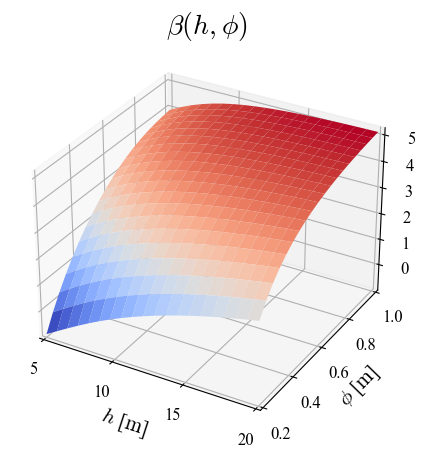

In [21]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax1 = fig.add_subplot(111, projection='3d')
ax1.plot_surface(hh/1000,dd/1000, beta_dum,cmap=plt.cm.coolwarm)

# Enhance the plot
ax1.set_xlim(h_dum[0]/1000,h_dum[-1]/1000)
ax1.set_ylim(d_dum[0]/1000,d_dum[-1]/1000)

ax1.set_xlabel(r'$h$ [m]',fontsize=15)
ax1.set_ylabel(r'$\phi$ [m]',fontsize=15)
ax1.set_title(r'$\beta(h,\phi)$',fontsize=20)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax1.zaxis.set_tick_params(labelsize=12)

plt.tight_layout()
plt.show()

## Task 4

In [22]:
# Optimization problem
# Cost Inputs: =================================================

C_0 = 50e3                                               # Fixed construction cost [NOK]
c_pile = 1e-5                                            # Cost of pile pr mm3 [NOK/mm3]
N_F = 5                                                  # Expected fatalities given failure
i_e = 0.03                                               # Interest rate
i_s = 0.025                                              # Societal interest rate
T_sl = 50                                                # Service live [years]
SWTP = 32.1e6                                            # NOK
H = 20*C_0                                               # Failure cost
D = 2*C_0                                                # Demolition cost
w = 1/T_sl                                               # Obsolence rate

In [23]:
n=20                                                     # Again, resolution of plots

h_dum = np.linspace(5e3, 20e3,n)
d_dum = np.linspace(0.2e3, 1e3,n)

hh, dd = np.meshgrid(h_dum,d_dum)

PF_1 = lambda h, d: scipy.stats.norm.cdf(-f1(h,d))       # Annual probability of failure

pf_1 = np.zeros_like(hh)
C_1 = np.zeros_like(hh)

V = lambda h,d: A(d)*h                                   # Volume of pile given height and diameter

for i in range(n):
    for j in range(n):
        pf_1[i,j] = PF_1(hh[i,j], dd[i,j])
        C_1[i,j] = V(hh[i,j], dd[i,j]) * c_pile

In [24]:
C_c = C_0 + C_1                                          # Construction cost
EC_f =  (C_c + H)* pf_1/i_e                              # Infite renewal expected failure cost
EC_obs = (C_c + D)*w/i_e                                 # Infinte renewal expected obsolence cost
EC_tot = C_c + EC_f + EC_obs                             # Excpected total cost

In [25]:
from matplotlib import ticker

def plotZ(Z,Tittel,pos):
    ax1 = fig.add_subplot(pos,projection='3d')
    ax1.plot_surface(hh/1000,dd/1000,Z,cmap=plt.cm.coolwarm)
    ax1.set_xlim(h_dum[0]/1000,h_dum[-1]/1000)
    ax1.set_ylim(d_dum[0]/1000,d_dum[-1]/1000)
    ax1.set_xlabel('h [m]',fontsize=15)
    ax1.set_ylabel('d [m]',fontsize=15)
    ax1.set_zlabel("NOK",rotation=90,labelpad=5,fontsize=15)
    ax1.set_title(Tittel,fontsize=20)
    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-1,1))
    ax1.zaxis.set_major_formatter(formatter) 
    ax1.xaxis.set_tick_params(labelsize=12)
    ax1.yaxis.set_tick_params(labelsize=12)
    ax1.zaxis.set_tick_params(labelsize=12)

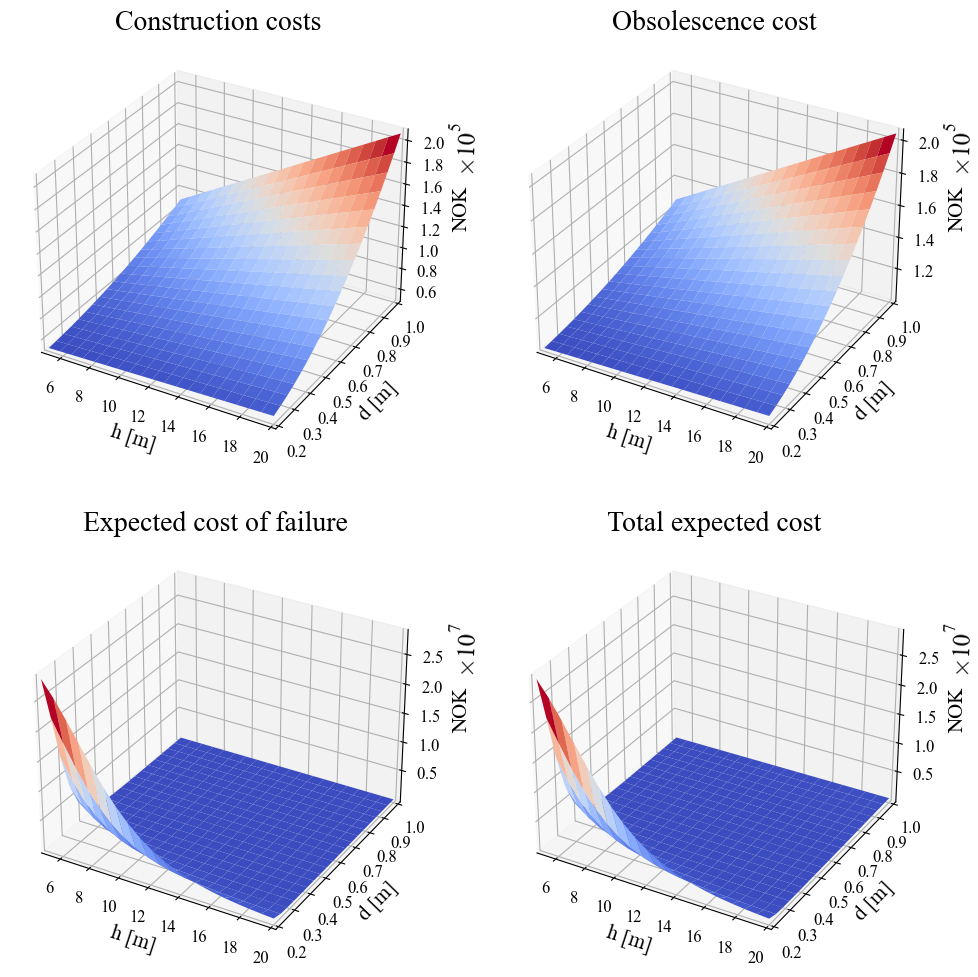

In [26]:
fig = plt.figure(figsize=(10,10))
plotZ(C_c,'Construction costs',221)
plotZ(EC_obs,"Obsolescence cost",222)
plotZ(EC_f,"Expected cost of failure ",223)
plotZ(EC_tot,"Total expected cost",224)
plt.tight_layout()
fig.subplots_adjust(wspace=.1,hspace=.2)
plt.show()

## Task 5

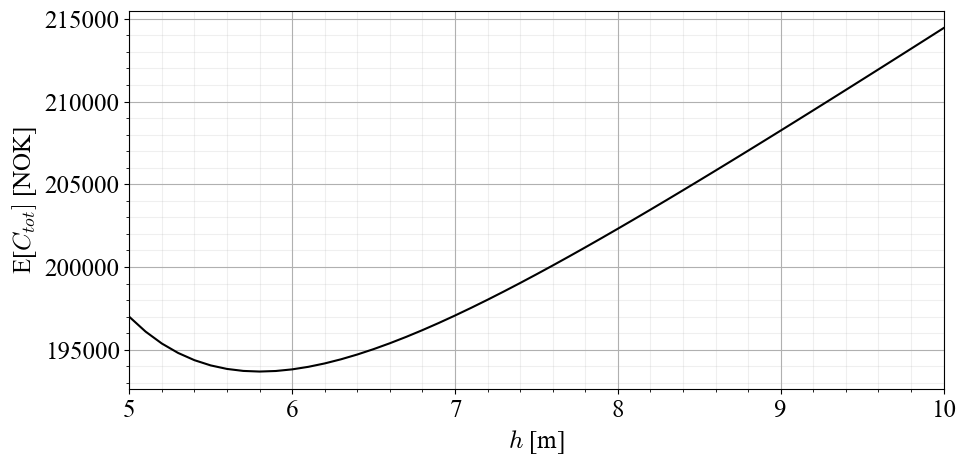

In [27]:
n=50

d_opt = 700

h_dum = np.linspace(5e3, 10e3,n+1)


C_1 = lambda h: c_pile * V(h, d_opt)

C_c = lambda h: C_0 + C_1(h)

EC_obs = lambda h: (C_c(h) + D)*w/i_e

EC_f = lambda h: (C_c(h)+H) * PF_1(h, d_opt)*1/i_e

f2 = lambda h: float(C_c(h) + EC_obs(h) + EC_f(h) )


fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.plot(h_dum/1000,np.vectorize(f2)(h_dum),'k')
ax.set_xlabel(r'$h$ [m]')
ax.set_xlim(h_dum[0]/1000,h_dum[-1]/1000)
ax.set_ylabel(r'E[$C_{tot}]$ [NOK]')
ax.grid(which='major')
ax.minorticks_on()
ax.grid(which='minor', alpha=0.2)
fig.tight_layout()
plt.show()

In [28]:
res=scipy.optimize.minimize(f2,6e3,method='nelder-mead',options={'xatol': 1e-2})
h_opt=float(res.x)
ECtot_opt = float(res.fun)
print(res)
print('\nOptimal height: %.0f mm \nOptimal expected total costs: %.0f NOK' % (h_opt, ECtot_opt))

 final_simplex: (array([[5801.11083984],
       [5801.10168457]]), array([193676.69550286, 193676.69550306]))
           fun: 193676.6955028569
       message: 'Optimization terminated successfully.'
          nfev: 34
           nit: 17
        status: 0
       success: True
             x: array([5801.11083984])

Optimal height: 5801 mm 
Optimal expected total costs: 193677 NOK


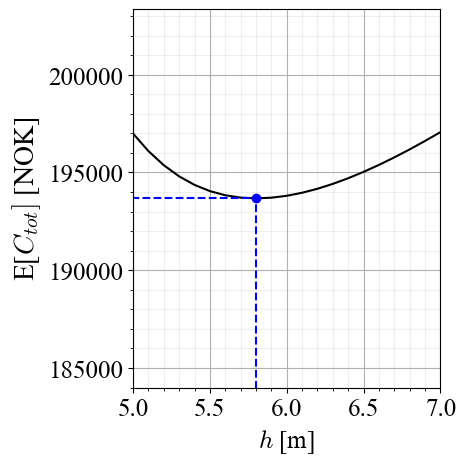

In [29]:
def hjelpelinjer(ax, x,y, c='b',label=None):
    ax.plot([x,x],[0,y],(c + '--'))
    ax.plot([0,x],[y,y],(c + '--'))
    ax.plot(x,y,(c + 'o'),label=label)

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
ax.plot(h_dum/1000,np.vectorize(f2)(h_dum),'k')
hjelpelinjer(ax, h_opt/1000,f2(h_opt))
ax.set_xlabel(r'$h$ [m]')
ax.set_xlim(5,7)
ax.set_ylabel(r'E[$C_{tot}]$ [NOK]',fontsize=20)
ax.set_ylim(ECtot_opt*0.95, ECtot_opt*1.05)
ax.grid(which='major')
ax.minorticks_on()
ax.grid(which='minor', alpha=0.2)
fig.tight_layout()
plt.show()

## Task 6

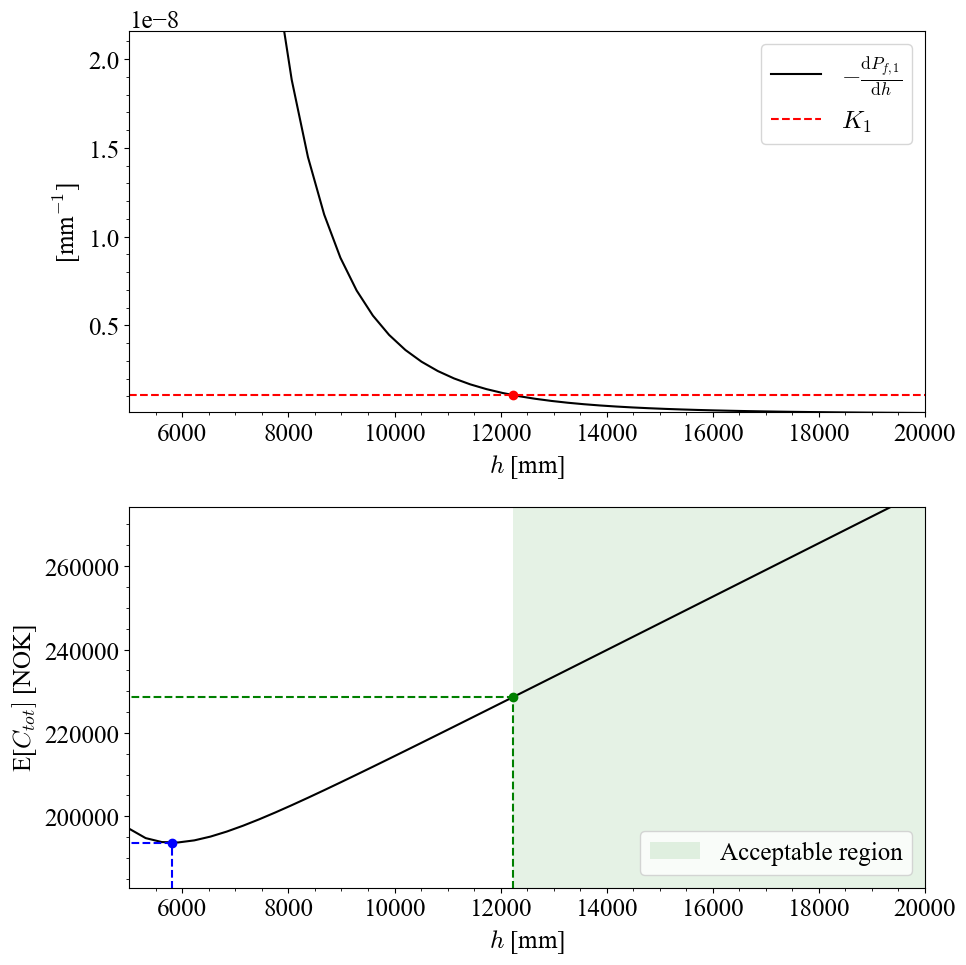

Minimal accepted height: 12233 mm
The optimal design is not acceptable.


In [30]:
h_dum = np.linspace(5000,20000,50)

C1 = c_pile*np.pi/4*d_opt**2
K1 = C1*(i_s + w)/(SWTP*N_F)

#Numerical differentation:
dh = 1
dPdh = lambda h: (PF_1(h+dh, d_opt) - PF_1(h-dh, d_opt)) / (2*dh)

#Finding the height, h_min, which gives -dPdh = K1
equation = lambda h: -dPdh(h) - K1

h_min = float(fsolve(equation, 12000))

fig = plt.figure(figsize=(10,10))

ax1 = fig.add_subplot(211)
ax1.plot(h_dum,-np.vectorize(dPdh)(h_dum),'k',label=r'$-\frac{\mathrm{d}P_{f,1}}{\mathrm{d}h}$')
ax1.plot([h_dum[0],h_dum[-1]],[K1,K1],'r--',label='$K_1$')
ax1.plot(h_min,K1,'ro')
ax1.set_xlabel('$h$ [mm]')
ax1.set_ylabel('[mm$^{-1}$]')
ax1.set_xlim(h_dum[0],h_dum[-1])
ax1.set_ylim(K1*0.1, K1*20)
ax1.minorticks_on()
ax1.legend()

ax2 = fig.add_subplot(212)
ax2.plot(h_dum, np.vectorize(f2)(h_dum),'k')
ax2.axvspan(h_min,h_dum[-1],facecolor='g',alpha=0.1,label='Acceptable region')
ax2.set_xlim(h_dum[0],h_dum[-1])
ax2.set_ylim(f2(h_min)*0.8,f2(h_min)*1.2)
ax2.set_xlabel('$h$ [mm]')
ax2.set_ylabel(r'E[$C_{tot}]$ [NOK]')
hjelpelinjer(ax2, h_opt, f2(h_opt),'b')
hjelpelinjer(ax2, h_min, f2(h_min),'g')
ax2.minorticks_on()
ax2.legend(loc='lower right')

fig.tight_layout()
plt.show()

if h_min <= h_opt:
    res = 'acceptable'
else:
    res = 'not acceptable' 

print('Minimal accepted height: %.0f mm' % h_min)
print('The optimal design is %s.' %res)